In [609]:
%%capture
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from scipy.special import gammaln, betaln, binom
%matplotlib inline

In [21]:
np.random.dirichlet(np.ones(5))

array([ 0.07299006,  0.06807584,  0.39421284,  0.15596882,  0.30875244])

In [96]:
def empirical(alpha):
    p = np.random.dirichlet(alpha, size=100000)
    result = np.mean(np.log(p[:, 0] + p[:, 1]))
    return result

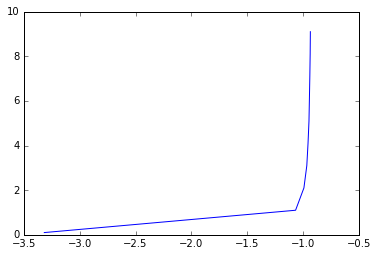

In [97]:
plt.plot([empirical(x*np.ones(5)) for x in np.arange(0.1, 10)], np.arange(0.1, 10))

In [112]:
def analytical(alpha, n_iter=1000):
    result = 0.
    alpha_x = alpha[0]
    alpha_y = alpha[1]
    alpha_z = np.sum(alpha[2:])
    for iter_i in range(1, n_iter+1):
        result += np.exp(betaln(alpha_x + iter_i, alpha_y + alpha_z) - betaln(alpha_x, alpha_y + alpha_z)) / iter_i
    return -result

In [115]:
analytical(2*np.ones(5))

-0.28571428571428431

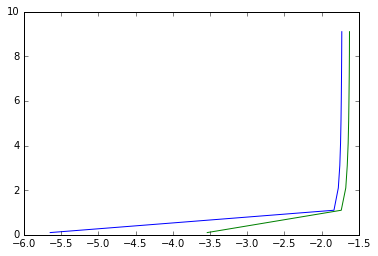

In [116]:
plt.plot([analytical(x*np.asarray([1, 2, 3, 4, 5])) * 24 for x in np.arange(0.1, 10)], np.arange(0.1, 10))
plt.plot([empirical(x*np.asarray([1, 2, 3, 4, 5])) for x in np.arange(0.1, 10)], np.arange(0.1, 10))

In [404]:
# since beta(a, b) can be very small we use logarithms

def log_mbeta1(a, b):
    """ 
    ln(-beta'(a, b))
    """
    return betaln(a, b) + np.log(-digamma(a) + digamma(a + b))

def beta1(a, b):
    return -np.exp(log_mbeta1(a, b))

def log_beta2(a, b):
    """
    ln(beta"(a, b))
    """
    return betaln(a, b) + np.log((digamma(a) - digamma(a + b))**2 + (polygamma(1, a) - polygamma(1, a + b)))

def beta2(a, b):
    return np.exp(log_beta2(a, b))

In [457]:
def empirical(alpha):
    p = np.random.dirichlet(alpha, size=100000)
    result = np.mean(np.log(p[:, 1]))
    return result

In [458]:
empirical(np.asarray([1, 4, 3]))

-0.76014801259751141

In [459]:
from scipy.special import digamma, gamma, gammaln, beta, betaln, polygamma
from scipy.misc import derivative

In [460]:
def log_mvbeta(*alphas):
    return np.sum([gammaln(alpha) for alpha in alphas]) - gammaln(np.sum(alphas))

In [461]:
def log_betaderiv_xy(x, y):
    result1 = betaln(x, y)
    result1 += np.log(digamma(x + y) - digamma(x))
    result1 += np.log(digamma(x + y) - digamma(y))
    result1 = np.exp(result1)
    
    result2 = betaln(x, y)
    result2 += np.log(polygamma(1, x + y))
    result2 = -np.exp(result2)
    
    return result1 + result2

In [488]:
def analytical(alpha, n_iter=1000):
    alpha_x = alpha[0]
    alpha_y = alpha[1]
    alpha_z = np.sum(alpha[2:])
    
    result1 = 0.
    result1 += log_mbeta1(alpha_y, alpha_z)
    result1 += betaln(alpha_x, alpha_y + alpha_z)
    result1 -= log_mvbeta(alpha_x, alpha_y, alpha_z)
    result1 = -np.exp(result1)
    print result1
    
    result2 = 0.
    result2 += betaln(alpha_y, alpha_z)
    result2 += log_mbeta1(alpha_y + alpha_z, alpha_x)
    result2 -= log_mvbeta(alpha_x, alpha_y, alpha_z)
    result2 = -np.exp(result2)
    print result2
        
    return result1 + result2

In [710]:
def log_beta_deriv(x, y, nx, ny):
    if nx < ny: 
        return log_beta_deriv(y, x, ny, nx)
    if nx == 0:
        return betaln(x, y), +1
    elif nx == 1 and ny == 0:
        return np.log(digamma(x + y) - digamma(x)) + betaln(x, y), -1
    elif nx == 2 and ny == 0:
        return np.log((digamma(x + y) - digamma(x)) ** 2 + (polygamma(1, x) - polygamma(1, x + y))) + \
            betaln(x, y), +1
    elif nx == 1 and ny == 1:
        return np.log((digamma(x + y) - digamma(x))*(digamma(x + y) - digamma(y)) - polygamma(1, x + y)) + \
            betaln(x, y), +1
    else:
        raise Exception("not implemented for nx={}, ny={}".format(nx, ny))

In [711]:
log_beta_deriv(4, 3, 0, 2), log_beta2(3, 4)

((-3.9599107990785671, 1), -3.9599107990785671)

In [720]:
def generic_analytical_expectation(alpha, m_x, k_x, m_y, k_y, x=0, y=1):
    result = 0.
    
    alpha_x = alpha[x]
    alpha_y = alpha[y]
    alpha_z = np.sum(alpha) - alpha_x - alpha_y
    
    for i in range(m_y + 1):
        current = 0.
        sign = +1
        
        d1_log, d1_sign = log_beta_deriv(alpha_x + k_x, 
                                         alpha_y + alpha_z + k_y, 
                                         m_x, i)
        
        current += d1_log
        sign *= d1_sign
        
        d2_log, d2_sign = log_beta_deriv(alpha_y + k_y, alpha_z,
                                         m_y - i, 0)

        current += d2_log
        sign *= d2_sign
        
    
        current -= log_mvbeta(alpha_x, alpha_y, alpha_z)

        result += sign * np.exp(current) * binom(m_y, i)
    
    return result

In [728]:
def analytical_covariance(alpha, x, y):
    return generic_analytical_expectation(alpha, 1, 1, 1, 1, x=x, y=y) - \
        (generic_analytical_expectation(alpha, 1, 1, 0, 0, x=x, y=y) * \
         generic_analytical_expectation(alpha, 0, 0, 1, 1, x=x, y=y))

In [729]:
def analytical_variance(alpha, x):
    y = (x + 1) % len(alpha)
    return generic_analytical_expectation(alpha, 2, 2, 0, 0, x=x, y=y) - \
        (generic_analytical_expectation(alpha, 1, 1, 0, 0, x=x, y=y)**2)

In [730]:
generic_analytical_expectation(np.asarray([1, 7, 3]), 1, 1, 1, 1)

0.052681553314663856

In [731]:
def empirical(alpha):
    p = np.random.dirichlet(alpha, size=1000000)
    result = np.mean(np.log(p[:, 0]) * p[:, 0] * \
                     np.log(p[:, 1]) * p[:, 1])
                    #p[:, 0] * p[:, 1])
    return result
empirical(np.asarray([1, 7, 3]))

0.05275876149484944

In [736]:
def empirical_variance(alpha):
    p = np.random.dirichlet(alpha, size=1000000)
    result = np.var(p[:, 0] * np.log(p[:, 0]), ddof=1)
    return result

In [739]:
empirical_variance([1, 2, 3, 4]), analytical_variance([1, 2, 3, 4], 0)

(0.010395361040976124, 0.010391893614515119)

In [747]:
analytical_covariance([1, 2, 3, 4], 0, 1)

-0.00089116171960386403

In [742]:
def empirical_entropy_variance(alpha):
    p = np.random.dirichlet(alpha, size=1000000)
    result = np.var(np.sum(p * np.log(p), axis=1), ddof=1)
    return result

In [743]:
empirical_entropy_variance([1, 2, 3])

0.027544509504125111

In [755]:
alpha = np.random.dirichlet(np.ones(10)) * 100
empirical_entropy_variance(alpha)

0.0037167156677290129

In [752]:
def entropy_variance_analytical(alpha):
    result = 0.
    for i, alpha_i in enumerate(alpha):
        result += analytical_variance(alpha, i)
    for i, alpha_i in enumerate(alpha):
        for j, alpha_j in enumerate(alpha):
            if i == j: continue
            result += analytical_covariance(alpha, i, j)
    return result

In [753]:
entropy_variance_analytical([1, 2, 3])

0.027574218952516792

In [756]:
entropy_variance_analytical(alpha)

0.003710246723882025